# Detection - **Post-processing**

**Content**

- `clear_outside_frame_range` to remove the background off the track
- `remove_outliers`
- `interpolate_missing_coordinates` with `median_filter` and `Savitzky_Golay_filter`

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import pandas as pd
from scipy.signal import medfilt
from scipy.signal import savgol_filter

Auxiliary data and functions

In [8]:
def plot_trajectory(df):
    plt.figure(figsize=(6, 4))
    plt.plot(df["x"], -df["y"], "o-", label="Cleaned Trajectory", markersize=5)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Cleaned Ball Trajectory")
    plt.legend()
    plt.show()

In [9]:
def plot_trajectories(raw_df, cleaned_df):
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot the original (raw) data on the left subplot
    axes[0].plot(raw_df["x"], -raw_df["y"], "o-", label="Trajectory", markersize=5)
    axes[0].set_title("Previous Ball Trajectory")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")
    axes[0].legend()

    # Plot the cleaned data on the right subplot
    axes[1].plot(
        cleaned_df["x"], -cleaned_df["y"], "o-", label="Trajectory", markersize=5
    )
    axes[1].set_title("Processed Ball Trajectory")
    axes[1].set_xlabel("X Coordinate")
    axes[1].set_ylabel("Y Coordinate")
    axes[1].legend()

    # Adjust layout for better appearance
    plt.tight_layout()
    plt.show()

In [10]:
def plot_comparison(df, df_cleaned):
    # Create a mask identifying outlier rows (i.e. those with NaN in x or y in the cleaned version)
    outlier_mask = df_cleaned[["x", "y"]].isna().any(axis=1)

    # Create a figure with two side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot 1: Original Data with Outliers Highlighted
    # Plot valid points from the original data (non-outliers)
    axes[0].plot(
        df.loc[~outlier_mask, "x"],
        -df.loc[~outlier_mask, "y"],
        "o-",
        label="Valid Points",
        color="blue",
        markersize=5,
    )
    # Overlay the outliers in red
    axes[0].plot(
        df.loc[outlier_mask, "x"],
        -df.loc[outlier_mask, "y"],
        "o",
        label="Outliers",
        color="red",
        markersize=5,
    )
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")
    axes[0].set_title("Original Points with Outliers Highlighted")
    axes[0].legend()

    # Plot 2: Cleaned Data
    # Plot only the non-NaN points from the cleaned DataFrame (which are the valid ones)
    valid_cleaned = df_cleaned.dropna(subset=["x", "y"])
    axes[1].plot(
        valid_cleaned["x"],
        -valid_cleaned["y"],
        "o-",
        label="Cleaned Trajectory",
        color="green",
        markersize=5,
    )
    axes[1].set_xlabel("X Coordinate")
    axes[1].set_ylabel("Y Coordinate")
    axes[1].set_title("Cleaned Points Only")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

Clean the points before a certain frame and after another one

In [11]:
def remove_custom_outliers(df):
    df = df.copy()
    condition_coord = (df["x"] < 900) & (
        df["y"] > -700
    )  # Change this with what I know about the starting point of the ball
    condition_radius = (df["radius"] < 38) & (
        df["radius"] > 82
    )  # Change this with what I know about the radius of the ball
    df.loc[condition_coord | condition_radius, ["x", "y", "radius"]] = np.nan
    return df

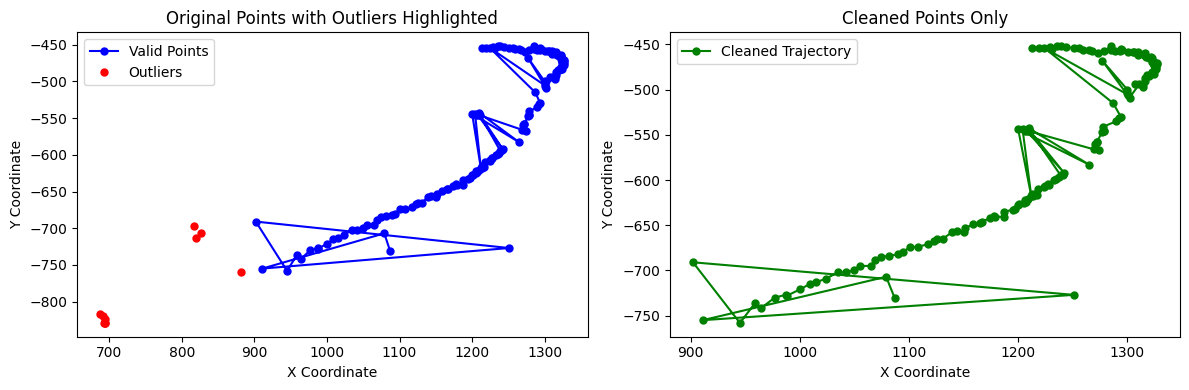

In [12]:
# Example usage
PROJECT_ROOT = Path().resolve().parent.parent
CSV_POSITIONS_FILE_PATH = str(
    PROJECT_ROOT
    / "notebook"
    / "ball_detection"
    / "intermediate_data"
    / "Circle_positions_raw_2.csv"
)
df = pd.read_csv(CSV_POSITIONS_FILE_PATH)

df_resized = remove_custom_outliers(df)
plot_comparison(df, df_resized)

Post-processing on the points removing the outliers

In [13]:
def remove_outliers_local(df, window, threshold):
    df = df.copy()

    # Calculate the rolling median for each coordinate (centered window)
    median_x = df["x"].rolling(window=window, center=True, min_periods=1).median()
    median_y = df["y"].rolling(window=window, center=True, min_periods=1).median()

    # Compute the Euclidean distance from the local median for each point
    diff = np.sqrt((df["x"] - median_x) ** 2 + (df["y"] - median_y) ** 2)

    # Flag points where the difference exceeds the threshold
    outliers = diff > threshold

    # Optionally, you can print or log which frames are flagged:
    print("Outlier frames:", df[outliers]["frame"].values)

    # Set outlier coordinates to NaN
    df.loc[outliers, ["x", "y", "radius"]] = np.nan

    return df

Outlier frames: [ 44  49  50  51  52 113 115 116 117 118 119 120 121 135 142]


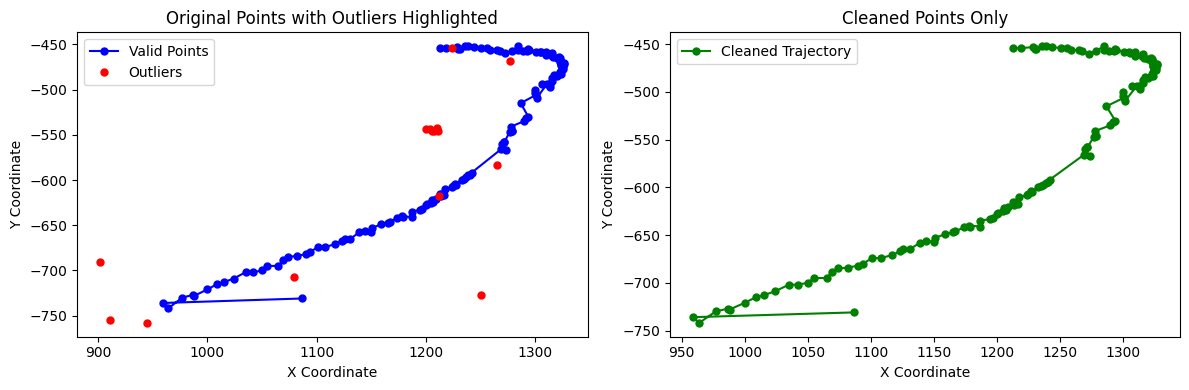

In [14]:
# Example usage
df_cleaned = remove_outliers_local(df_resized, window=15, threshold=30)
plot_comparison(df_resized, df_cleaned)

In [15]:
def median_filter(df, kernel_size=5):
    df = df.copy()
    # Apply a median filter to smooth the coordinates (kernel size 5 by default)
    df["x"] = medfilt(df["x"], kernel_size=kernel_size)
    df["y"] = medfilt(df["y"], kernel_size=kernel_size)

    df = df[
        df["x"] > 0
    ]  # Because I had the problem witht he point 0,0 (I don't know why)
    df = df[df["y"] > 0]
    return df

In [16]:
def Savitzky_Golay_filter(df, window_length=25, polyorder=1):
    df = df.copy()
    df["x"] = savgol_filter(df["x"], window_length=window_length, polyorder=polyorder)
    df["y"] = savgol_filter(df["y"], window_length=window_length, polyorder=polyorder)
    # Round the smoothed coordinates to integers
    df["x"] = df["x"].round().astype(int)
    df["y"] = df["y"].round().astype(int)

    return df

In [17]:
def interpolate_missing_coordinates(df):
    # Copy and set "frame" as the index
    df = df.copy().set_index("frame")

    # Create a new index that includes all frames from first to last
    full_index = range(df.index.min(), df.index.max() + 1)
    df_full = df.reindex(full_index)

    # Interpolate missing 'x' and 'y' coordinates (linear interpolation)
    df_full["x"] = df_full["x"].interpolate(method="linear")
    df_full["y"] = df_full["y"].interpolate(method="linear")

    # Fill any remaining NaN values using forward and backward filling
    df_full["x"] = df_full["x"].bfill().ffill()
    df_full["y"] = df_full["y"].bfill().ffill()

    # Reset index to bring the "frame" column back
    df_full = df_full.reset_index().rename(columns={"index": "frame"})

    # Apply smoothing to ensure a smooth trajectory
    df_full = Savitzky_Golay_filter(df_full)

    return df_full

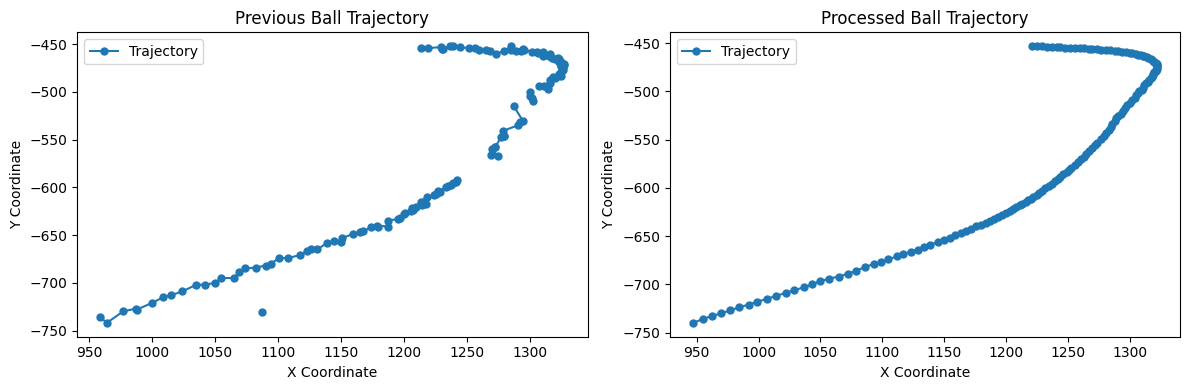

In [18]:
# Smooth the trajectory to reduce noise
df_smoothed = median_filter(df_cleaned)

# Interpolate missing coordinates
df_interpolated = interpolate_missing_coordinates(df_smoothed)

# Now you can plot the result
plot_trajectories(df_cleaned, df_interpolated)

In [ ]:
# Save the smoothed and interpolated data
OUTPUT_CSV_PATH = str(
    PROJECT_ROOT
    / "data"
    / "auxiliary_data"
    / "circle_positions"
    / "Circle_positions_processed_2.csv"
)
df_interpolated.to_csv(OUTPUT_CSV_PATH, index=False)

# Save cleaned data
OUTPUT_CSV_PATH = str(
    PROJECT_ROOT
    / "notebook"
    / "ball_detection"
    / "intermediate_data"
    / "Circle_positions_cleaned_2.csv"
)
df_cleaned.to_csv(OUTPUT_CSV_PATH, index=False)

TODO: start and finish detection when the ball enters and exits the track (required track detection). How to know when the ball is arrived at the end?

Do not do the interpolation with this data but with the data reconstructed on the lane reconstruction!!!